In [1]:
import pathlib
import pickle

import astropy.table as at
import astropy.units as u
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import gala.potential as gp
import gala.integrate as gi
import numpy as np
from gala.units import galactic
import jax.numpy as jnp
from scipy.stats import binned_statistic
import torusimaging as oti
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
    plot_az_Jz,
    plot_orbit_shapes,
)
from torusimaging_helpers.config import gala_pot, agama_pot, R0, vc0
import agama

jax.config.update("jax_enable_x64", True)

In [2]:
name = "qiso-sel"

pdata = at.QTable.read(f"../.cache/qiso-pdata.hdf5")
bdata = dict(np.load(f"../.cache/{name}-bdata.npz"))

# TODO: fix this!
if not hasattr(bdata["pos"], "unit"):
    bdata["pos"] = bdata["pos"] * u.kpc
    bdata["vel"] = bdata["vel"] * u.kpc / u.Myr

with open(f"../.cache/{name}-model.pkl", "rb") as f:
    model = pickle.load(f)

with open(f"../.cache/{name}-params-opt.pkl", "rb") as f:
    res_params = pickle.load(f)

with open(f"../.cache/{name}-mcmc-results.pkl", "rb") as f:
    mcmc_states, mcmc_params = pickle.load(f)

max_z = bdata["pos"].max()
max_vz = bdata["vel"].max()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# prob = ((np.abs(pdata["z"]) + 0.15 * u.kpc) / (2 * u.kpc)) ** 2
# prob /= prob.sum()

# rng = np.random.default_rng(42)
# idx = rng.choice(
#     np.arange(len(pdata)), size=len(prob) // 2, replace=False, p=prob
# )

# max_z = np.round(2 * np.nanpercentile(pdata["z"].to(u.kpc), 99), 1)
# max_vz = np.round(2 * np.nanpercentile(pdata["v_z"].to(u.km / u.s), 99), 0)

# zvz_bins = {
#     "pos": np.linspace(-max_z, max_z, 151),
#     "vel": np.linspace(-max_vz, max_vz, 151),
# }

# bdata = oti.get_binned_label(
#     pdata["z"][idx],
#     pdata["v_z"][idx],
#     label=pdata["mgfe"][idx],
#     label_err=pdata["mgfe_err"][idx],
#     bins=zvz_bins,
#     units=galactic,
# )

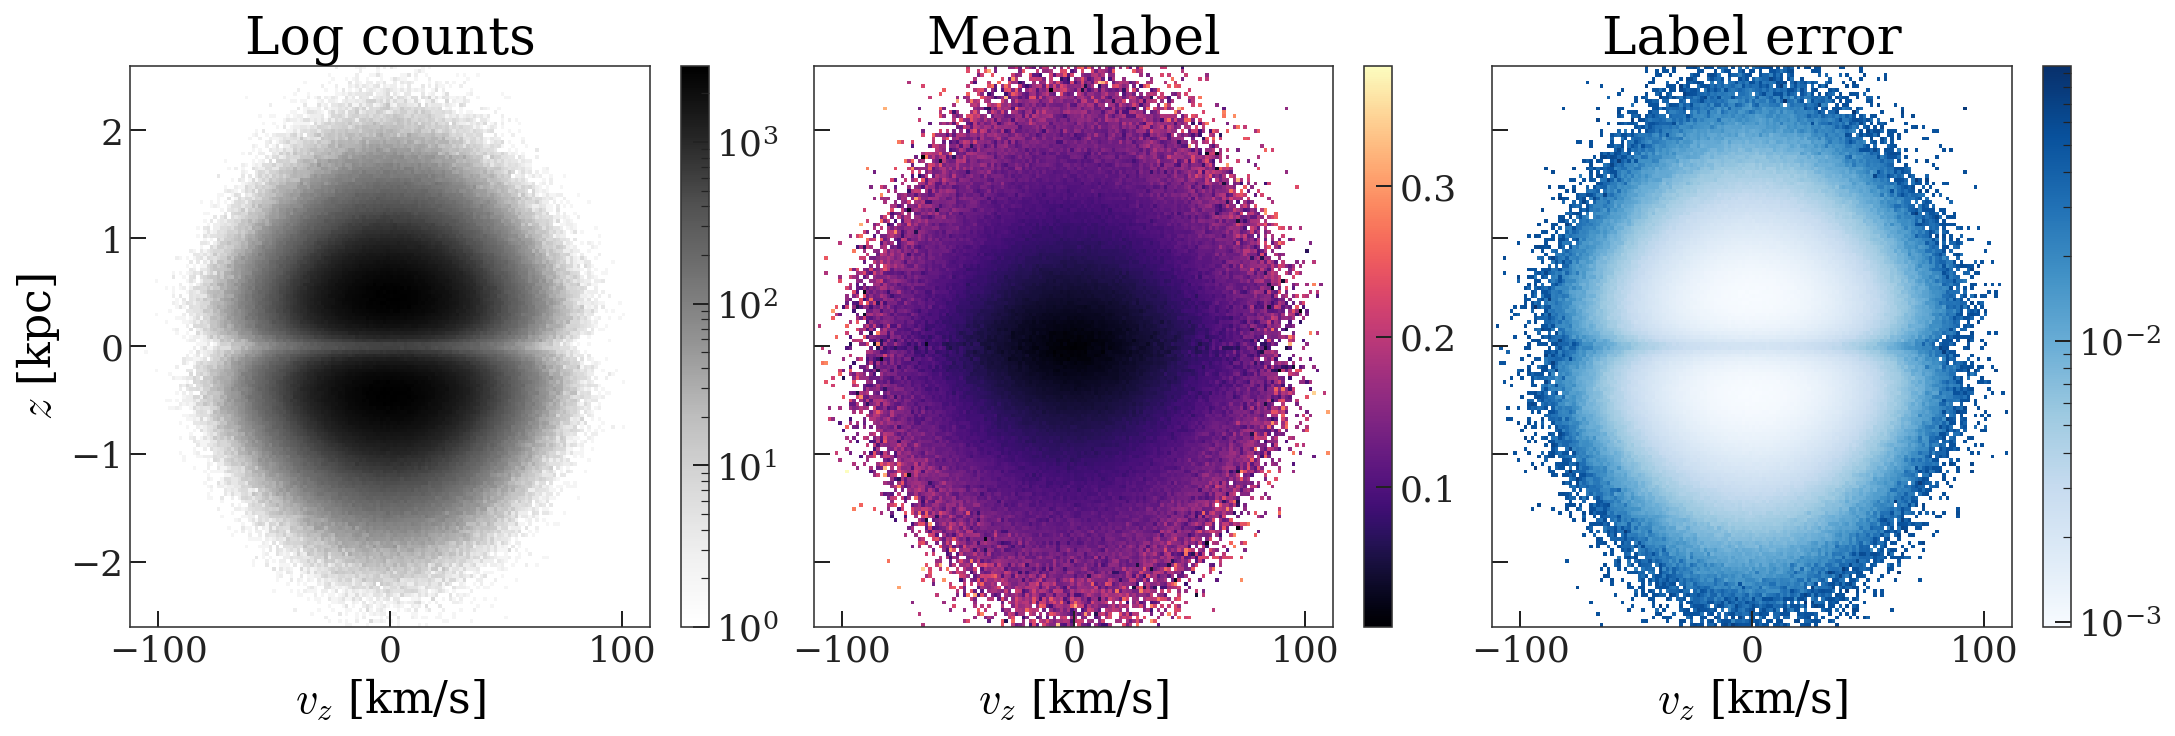

In [4]:
plot_bdata(bdata);

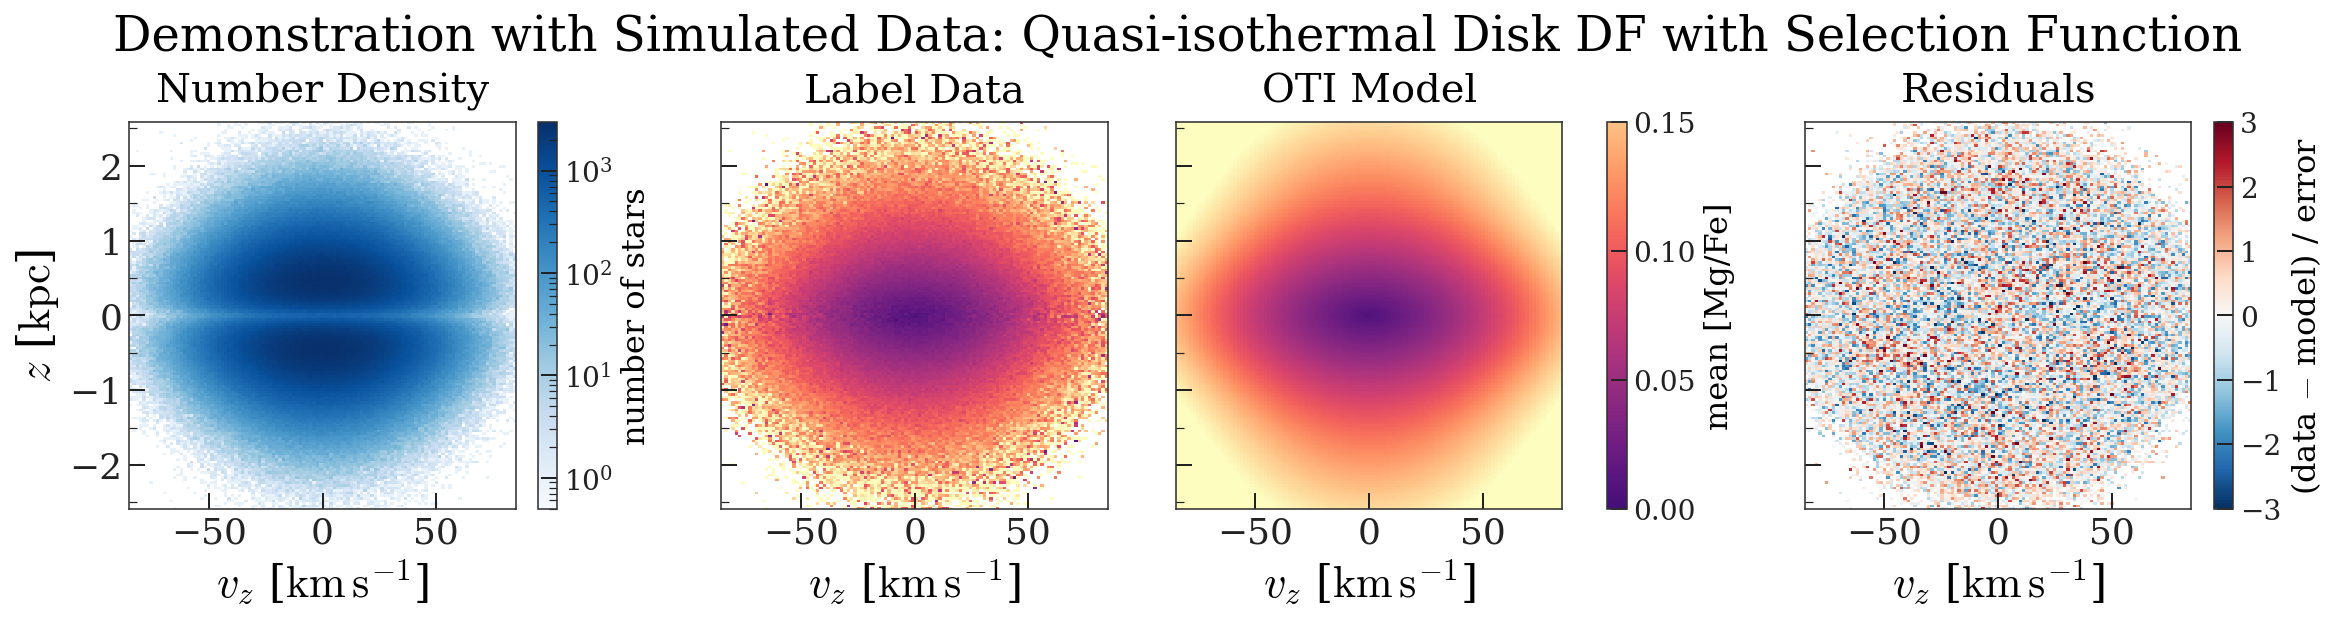

In [5]:
title = "Quasi-isothermal Disk DF with Selection Function"

fig, axes = plot_data_model_residual(
    model,
    bdata,
    res_params,
    zlim=max_z,
    suptitle2=title,
)
fig.savefig(
    f"../tex/figures/{name}-data-model.pdf",
    dpi=250,
    pad_inches=0.1,
    bbox_inches="tight",
)

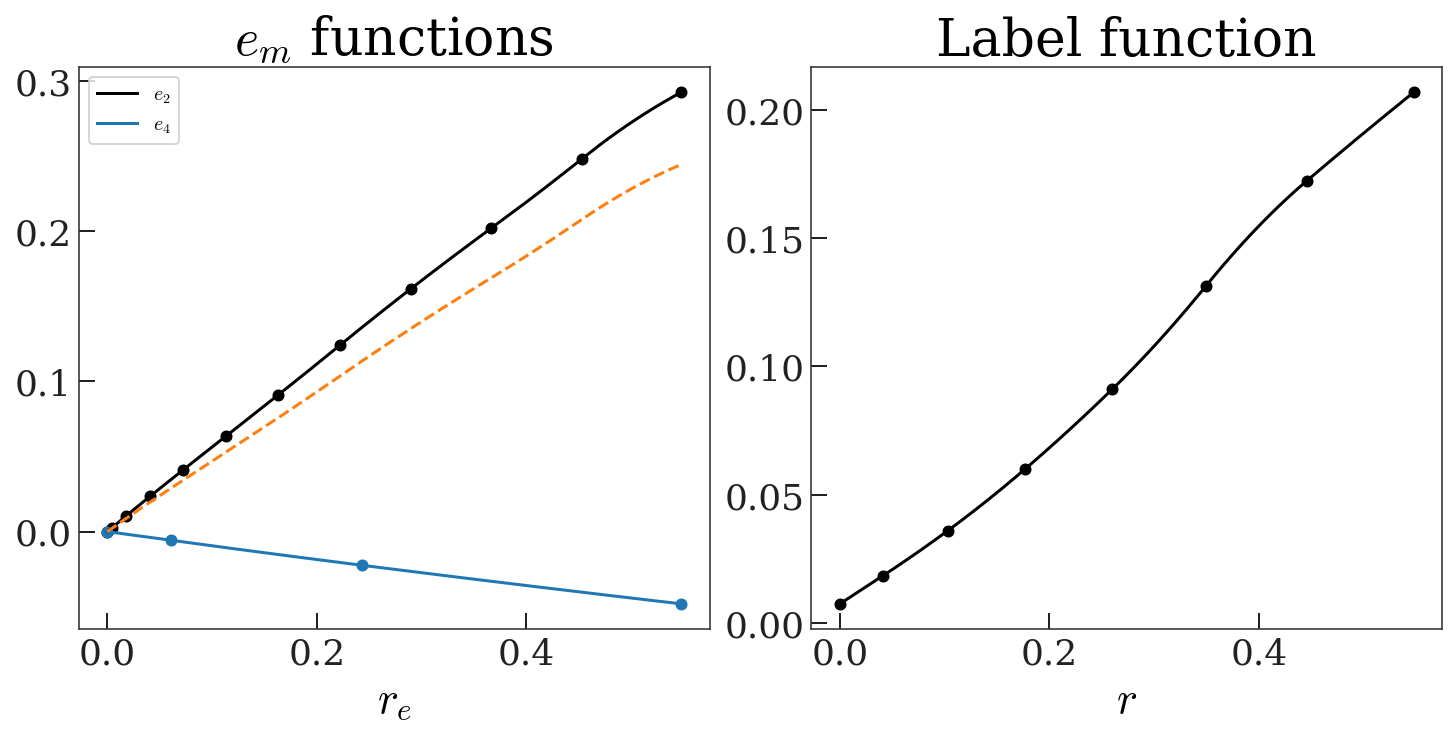

In [6]:
_ = plot_spline_functions(model, res_params)

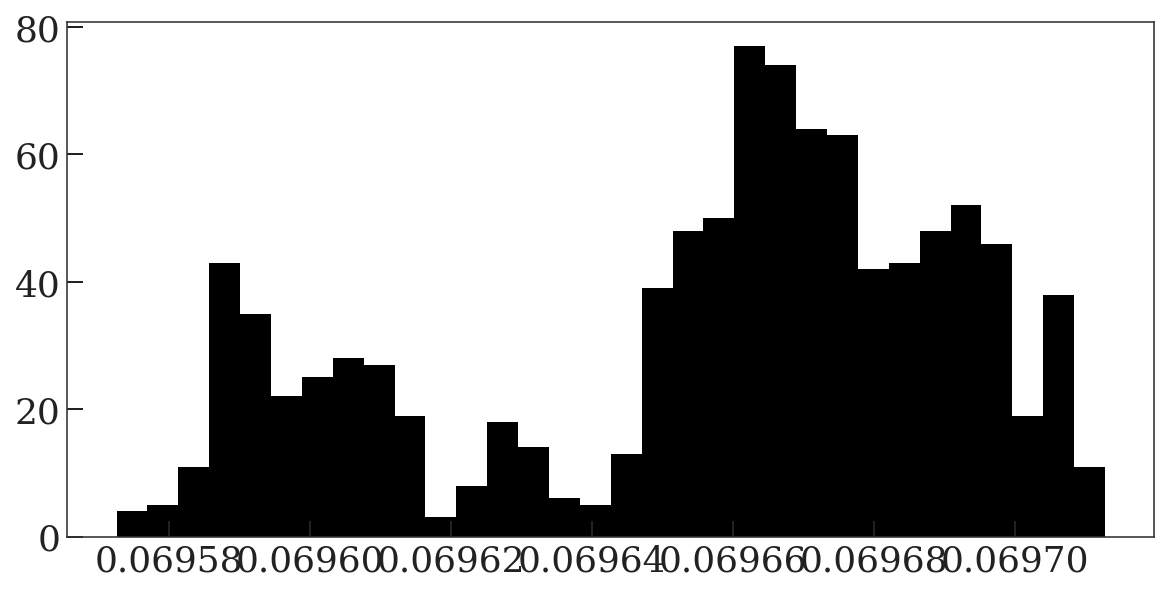

In [7]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
_ = ax.hist(np.exp(mcmc_states.position["ln_Omega0"]), bins=32)
# ax.axvline(true_Omega, color="tab:green")

In [8]:
accs = []
zgrid = np.linspace(-1, 1, 512) * max_z
for p in mcmc_params:
    acc = model.get_acceleration(zgrid, p)
    accs.append(acc.value)
accs = accs * acc.unit

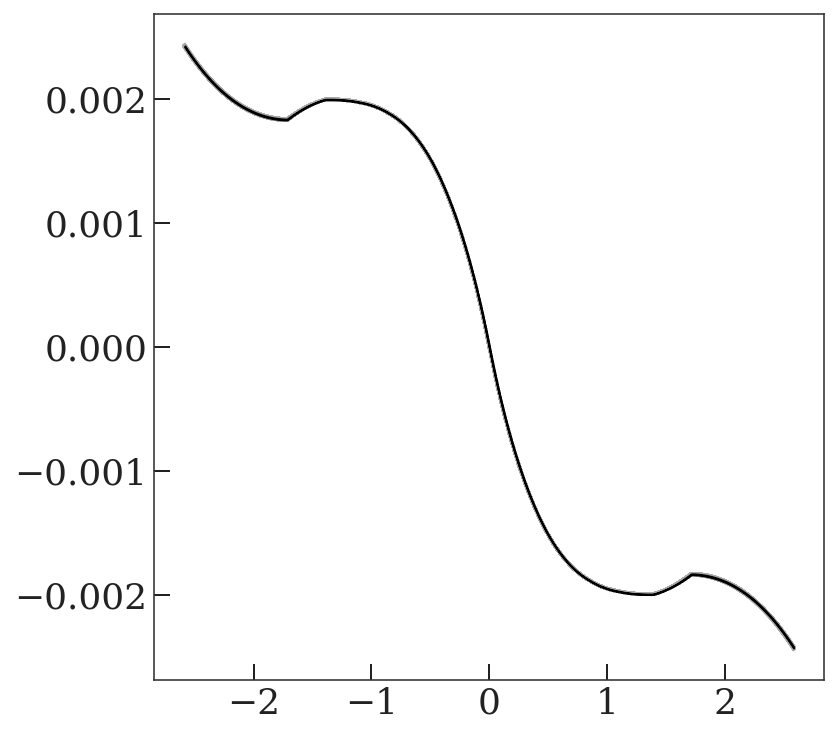

In [9]:
plt.plot(zgrid, accs.T, marker="", alpha=0.1, color="#aaaaaa")

p1, p2 = np.nanpercentile(accs.value, [16, 84], axis=0)
plt.fill_between(zgrid.value, p1, p2, color="k", zorder=10)

In [10]:
a_unit = u.km / u.s / u.Myr

xyz_grid = np.zeros((3, zgrid.size)) * u.kpc
xyz_grid[0] = R0
xyz_grid[2] = zgrid
true_acc = gala_pot.acceleration(xyz_grid)[2]

accs = accs.to(a_unit)
daccs = accs.T - true_acc[:, None]

In [11]:
MAP_idx = mcmc_states.logdensity.argmax()
MAP_params = mcmc_params[MAP_idx]

In [12]:
bestfit_acc = model.get_acceleration(zgrid, res_params).to(a_unit)
MAP_acc = model.get_acceleration(zgrid, MAP_params).to(a_unit)

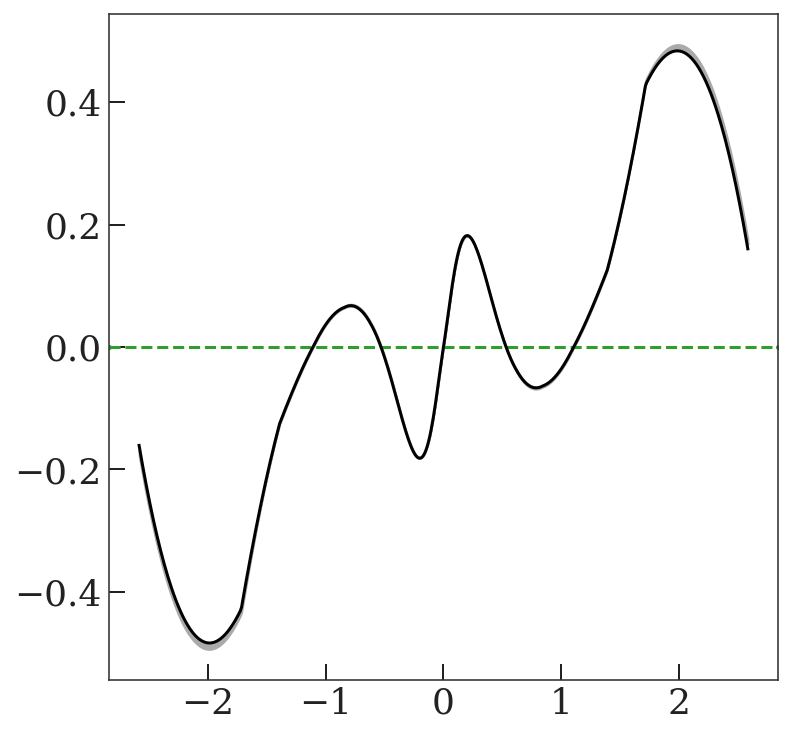

In [13]:
plt.axhline(0.0, ls="--", color="tab:green")
plt.plot(zgrid.value, MAP_acc - true_acc, marker="", color="k")
plt.fill_between(
    zgrid.value,
    (np.nanpercentile(daccs, 16, axis=1)).to_value(a_unit),
    (np.nanpercentile(daccs, 84, axis=1)).to_value(a_unit),
    zorder=-10,
    color="#aaaaaa",
)

In [16]:
subset_N = 100_000
aaf = model.compute_action_angle(
    pdata["z"][:subset_N], pdata["v_z"][:subset_N], res_params
)

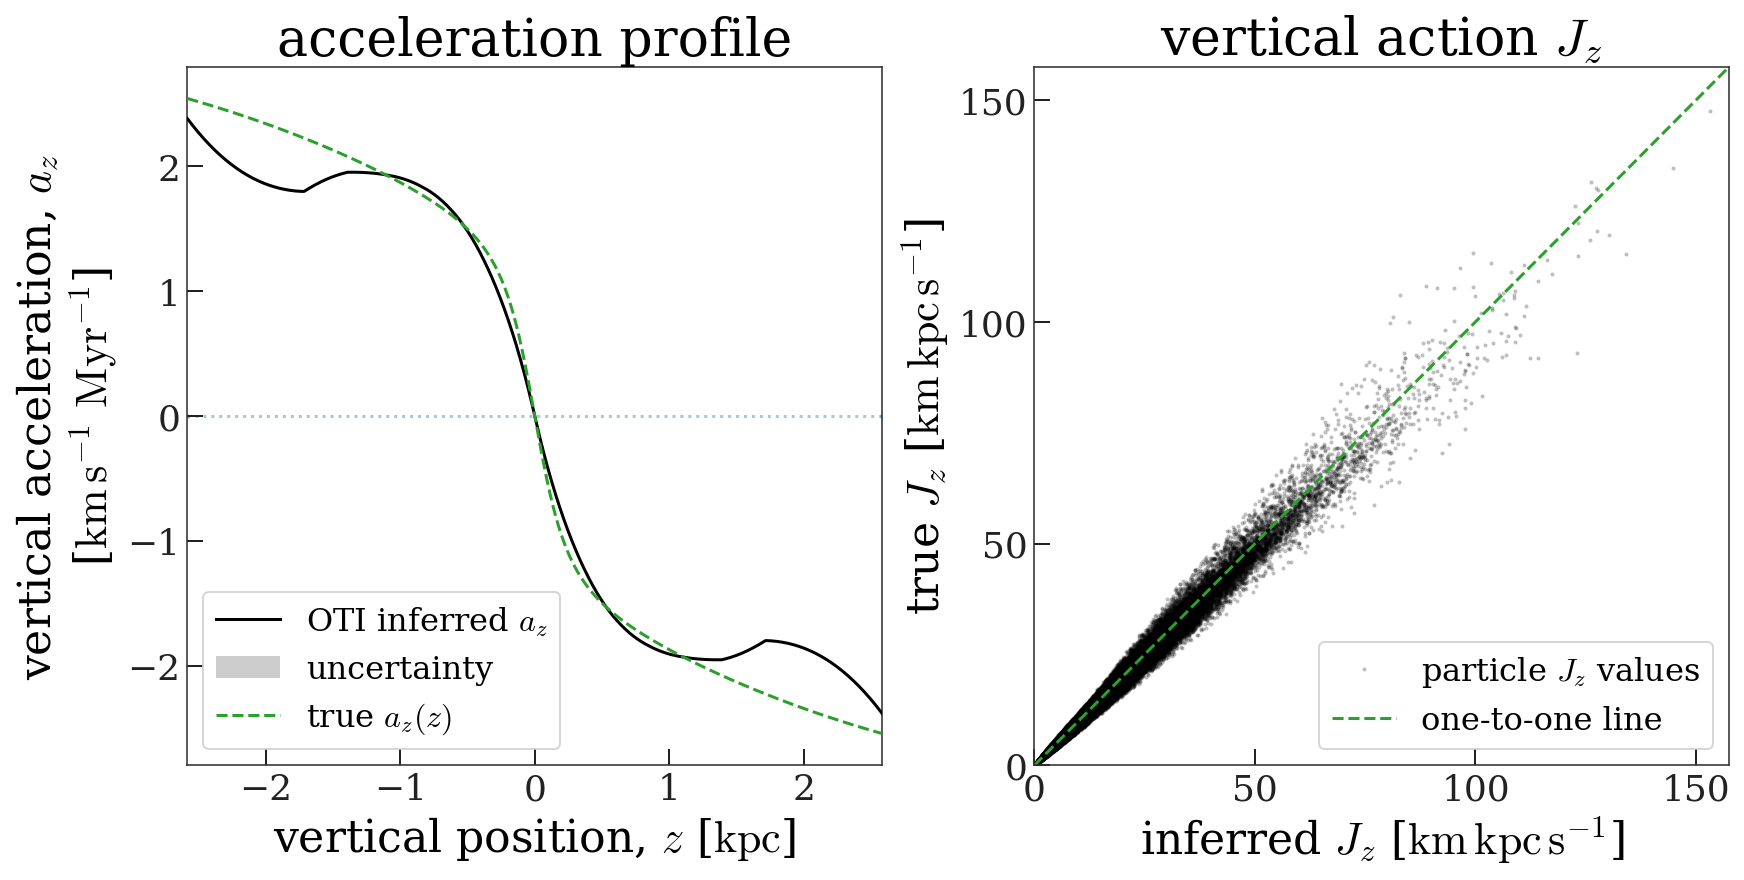

In [17]:
plot_az_Jz(MAP_acc, accs, zgrid, aaf, true_acc, pdata["J"][:subset_N, 2]);

In [18]:
zlim = np.array([-1, 1]) * max_z.value
vzlim = np.array([-1, 1]) * max_vz.to_value(u.km / u.s)

orbit_vzs = np.linspace(0, 1.0, 8 + 1)[1:] * max_vz * 0.9

In [19]:
xv = np.zeros((orbit_vzs.size, 6))
xv[:, 0] = R0.decompose(galactic).value
xv[:, 4] = vc0.decompose(galactic).value
xv[:, 5] = orbit_vzs.decompose(galactic).value

af = agama.ActionFinder(agama_pot)
*_, orbit_freqs = af(xv, angles=True)
orbit_freqz = orbit_freqs[:, 1]

In [20]:
Jzs = af(xv)[:, 1]
Jphi0 = (R0 * vc0).decompose(galactic).value

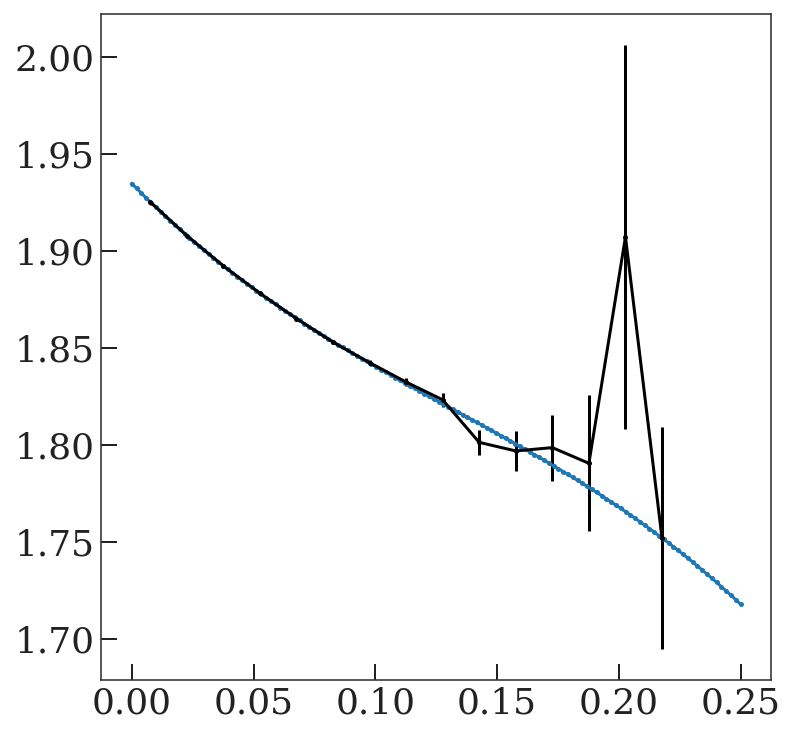

In [21]:
tmpJ = pdata["J"].value
stat = binned_statistic(
    tmpJ[:, 2], tmpJ[:, 1], bins=np.linspace(0, tmpJ[:, 2].max(), 16)
)
statN = binned_statistic(tmpJ[:, 2], tmpJ[:, 1], statistic="count", bins=stat.bin_edges)
stats = binned_statistic(tmpJ[:, 2], tmpJ[:, 1], statistic="std", bins=stat.bin_edges)
staterr = np.nanmean(stats.statistic) / np.sqrt(statN.statistic)
statx = 0.5 * (stat.bin_edges[:-1] + stat.bin_edges[1:])
plt.errorbar(statx, stat.statistic, staterr)

poly = np.polynomial.Polynomial.fit(statx, stat.statistic, deg=3, w=1 / staterr)
_grid = np.linspace(0, 0.25, 128)
plt.plot(_grid, poly(_grid))

In [22]:
N_steps = 1024
true_zvzs = np.zeros((len(orbit_vzs), 2, N_steps))
for i, (Jz, vv) in enumerate(zip(Jzs, orbit_vzs.decompose(galactic).value)):
    mapper = agama.ActionMapper(agama_pot, [0.0, Jz, poly(Jz)])
    ths = np.zeros((N_steps, 3))
    ths[:, 1] = np.linspace(0, 2 * np.pi, ths.shape[0])
    orbit = mapper(ths)

    true_zvzs[i, 0] = orbit[:, 2]
    true_zvzs[i, 1] = orbit[:, 5]

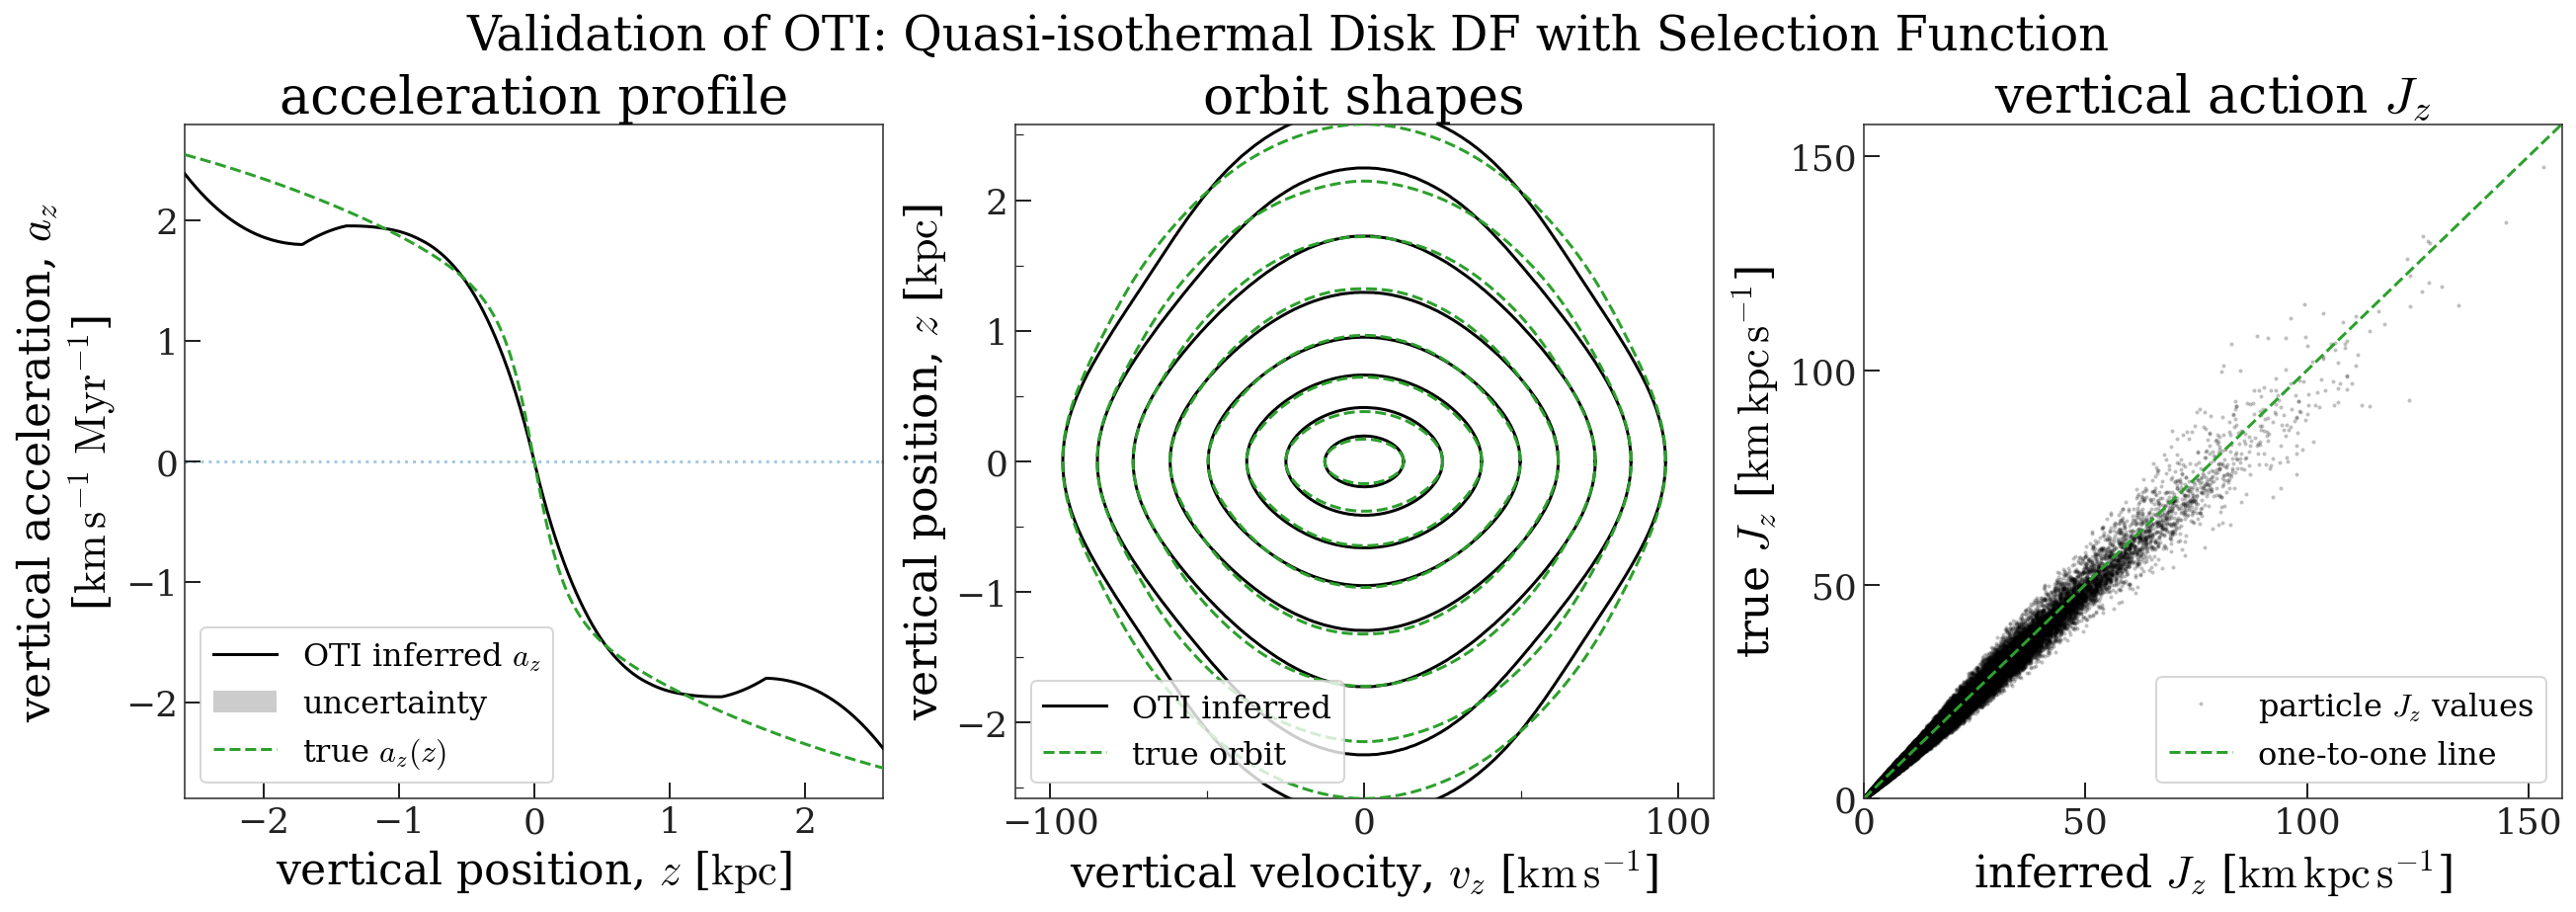

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6.3), layout="constrained")

plot_orbit_shapes(model, res_params, true_zvzs, zlim, vzlim, ax=axes[1])

plot_az_Jz(
    MAP_acc,
    accs,
    zgrid,
    aaf,
    true_acc,
    pdata["J"][:subset_N, 2],
    axes=[axes[0], axes[2]],
)
fig.suptitle(f"Validation of OTI: {title}", fontsize=25)

fig.savefig(
    f"../tex/figures/{name}-validation.pdf",
    dpi=250,
    pad_inches=0.1,
    bbox_inches="tight",
)

In [24]:
idx = np.abs(zgrid - 1 * u.kpc).argmin()
frac_dacc = (daccs / true_acc[:, None]).decompose()
np.median(frac_dacc[idx]), np.std(frac_dacc[idx]), np.diff(
    np.nanpercentile(frac_dacc[idx], [16, 84])
) / 2

(<Quantity 0.02007172>, <Quantity 0.00065309>, <Quantity [0.00069579]>)

In [25]:
frac_diff = (
    ((aaf["J"] - pdata["J"][:subset_N, 2]) / pdata["J"][:subset_N, 2]).decompose().value
)
np.median(frac_diff), np.std(frac_diff)

(-0.001238052381165669, 0.08435723848317232)